## Imports

In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
import pandas as pd
import math
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 980, pci bus id: 0000:26:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## The Original Datasets: Load, Normalize

In [18]:
# load from files
raw_original_test_labels = idx2numpy.convert_from_file('datasets/fashion_mnist_test_labels.idx')
raw_original_test_data = idx2numpy.convert_from_file('datasets/fashion_mnist_test_data.idx')
raw_original_train_labels = idx2numpy.convert_from_file('datasets/fashion_mnist_train_labels.idx')
raw_original_train_data = idx2numpy.convert_from_file('datasets/fashion_mnist_train_data.idx')

# normalization
original_test_labels = np.asarray(raw_original_test_labels, dtype=np.int32)
original_test_data = np.asarray(raw_original_test_data / 255.0, dtype=np.float32).reshape(-1, 28, 28, 1)
original_train_labels = np.asarray(raw_original_train_labels, dtype=np.int32)
original_train_data = np.asarray(raw_original_train_data / 255.0, dtype=np.float32).reshape(-1, 28, 28, 1)
original_val_labels = original_train_labels[45000:]
original_val_data = original_train_data[45000:]
original_train_labels = original_train_labels[:45000]
original_train_data = original_train_data[:45000]

## The Original Datasets: Display Some Images

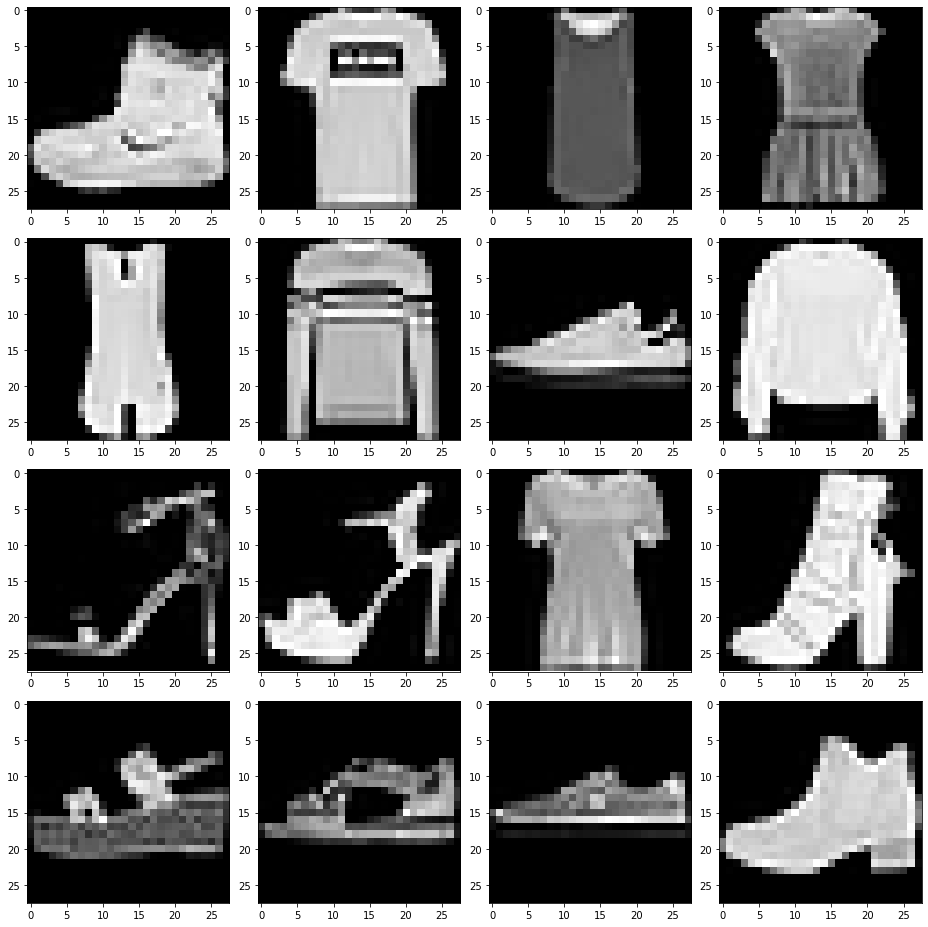

In [19]:
def display_first_16_images(data):
    fig = plt.figure(figsize=(13, 13))
    axes=[]
    for ii in range(16):
        axes.append(fig.add_subplot(4, 4, ii + 1) )
        plt.imshow(data[ii].reshape((28,28)))
    plt.tight_layout()
    plt.gray()

display_first_16_images(original_train_data)

## The /Augmented/ Datasets: Create generator

In [20]:
aug_data_generator_1 = ImageDataGenerator(rotation_range=5, horizontal_flip=True, vertical_flip=True, zoom_range=0.1)
aug_data_generator_2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=(0.9, 1.1),
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='constant',
    cval=0)

In [21]:
def augm_gen(data):
    aug_data_generator_1.fit(data)
    return aug_data_generator_1

## The /Augmented/ Datasets: Display Some of Images

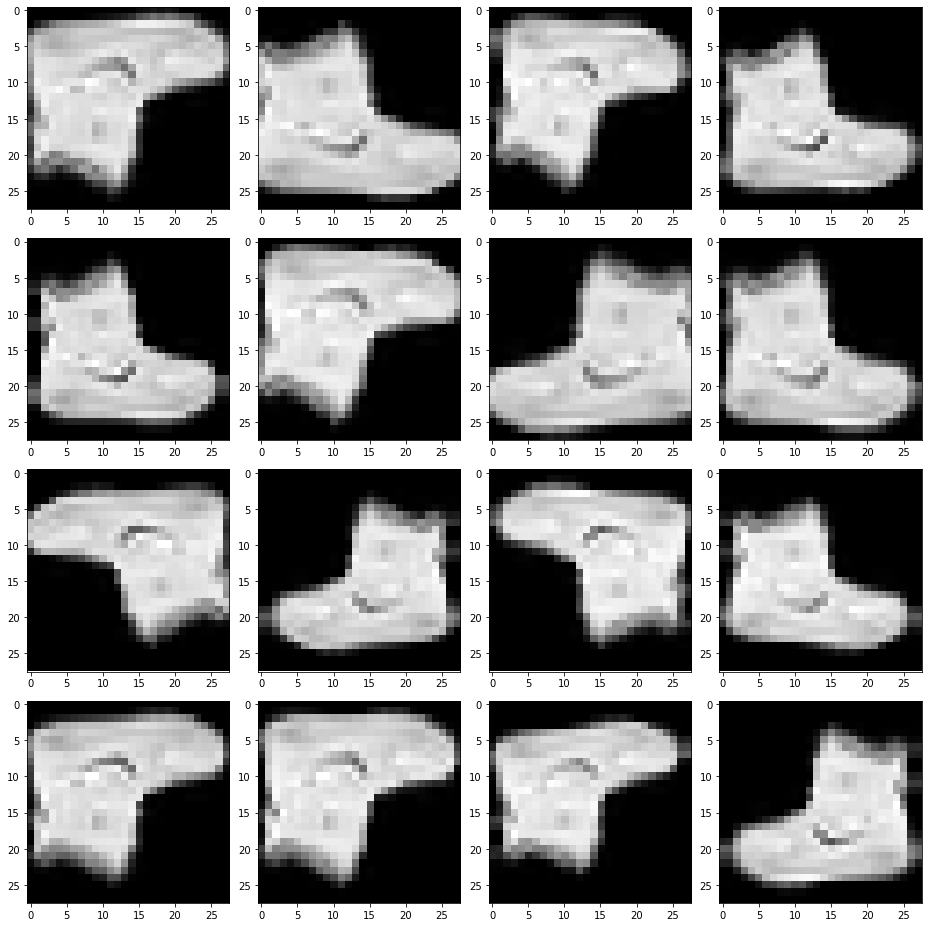

In [22]:
augmented_imgs = []
ii = 0
for batch in aug_data_generator_1.flow(original_train_data[0].reshape((1,28,28,1))):
    augmented_imgs.append(batch[0].reshape((28,28)))
    ii += 1
    if ii > 16:
        break
display_first_16_images(augmented_imgs)

## Create Łukasz's Models

In [23]:
IMG_SHAPE = (28,28,1)
from tensorflow.keras.optimizers import Adam

model_1 = keras.Sequential([
    Conv2D(32, (3, 3), input_shape=IMG_SHAPE, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), input_shape=IMG_SHAPE, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model_2 = keras.Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

model_3 = keras.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    Conv2D(256, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_3.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Create Stolen From Internet Model

In [24]:
model_4 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(10, activation='softmax') # output layer (3)
])
model_4.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## Train And Test Models - Original Data

In [31]:
batch_size = 64
epochs = 150
for ba in augm_gen(original_train_data).flow(original_train_data, original_train_labels, batch_size=batch_size):
    print(ba[0].shape)
    break
history_1 = model_1.fit(
        augm_gen(original_train_data).flow(original_train_data, original_train_labels, batch_size=batch_size),
        validation_data=(augm_gen(original_val_data).flow(original_val_data, original_val_labels, batch_size=batch_size)),
        steps_per_epoch=math.ceil(len(original_train_data) / batch_size), epochs=epochs,
        validation_steps=math.ceil(len(original_val_data) / batch_size))

(64, 28, 28, 1)
Epoch 1/150
704/704 [==============================] - 7s 10ms/step - loss: 0.3711 - accuracy: 0.8627 - val_loss: 0.3863 - val_accuracy: 0.8544
Epoch 2/150
704/704 [==============================] - 7s 10ms/step - loss: 0.3533 - accuracy: 0.8697 - val_loss: 0.3861 - val_accuracy: 0.8554
Epoch 3/150
704/704 [==============================] - 7s 10ms/step - loss: 0.3369 - accuracy: 0.8765 - val_loss: 0.3477 - val_accuracy: 0.8706
Epoch 4/150
704/704 [==============================] - 7s 10ms/step - loss: 0.3208 - accuracy: 0.8828 - val_loss: 0.3668 - val_accuracy: 0.8637
Epoch 5/150
704/704 [==============================] - 7s 10ms/step - loss: 0.3099 - accuracy: 0.8845 - val_loss: 0.4115 - val_accuracy: 0.8479
Epoch 6/150
704/704 [==============================] - 7s 10ms/step - loss: 0.3026 - accuracy: 0.8883 - val_loss: 0.3336 - val_accuracy: 0.8772
Epoch 7/150
704/704 [==============================] - 7s 10ms/step - loss: 0.2954 - accuracy: 0.8917 - val_loss: 0.3212

704/704 [==============================] - 7s 10ms/step - loss: 0.1585 - accuracy: 0.9399 - val_loss: 0.3038 - val_accuracy: 0.9010
Epoch 58/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1609 - accuracy: 0.9394 - val_loss: 0.3147 - val_accuracy: 0.9035
Epoch 59/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1599 - accuracy: 0.9396 - val_loss: 0.3149 - val_accuracy: 0.9015
Epoch 60/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1588 - accuracy: 0.9404 - val_loss: 0.3051 - val_accuracy: 0.9062
Epoch 61/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1546 - accuracy: 0.9412 - val_loss: 0.3014 - val_accuracy: 0.9055
Epoch 62/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1536 - accuracy: 0.9409 - val_loss: 0.3080 - val_accuracy: 0.9067
Epoch 63/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1525 - accuracy: 0.9422 - val_loss: 0.3106 - val_accuracy: 0.903

704/704 [==============================] - 7s 10ms/step - loss: 0.1203 - accuracy: 0.9550 - val_loss: 0.3544 - val_accuracy: 0.9031
Epoch 114/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1247 - accuracy: 0.9532 - val_loss: 0.3329 - val_accuracy: 0.9060
Epoch 115/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1211 - accuracy: 0.9545 - val_loss: 0.3480 - val_accuracy: 0.9068
Epoch 116/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1223 - accuracy: 0.9550 - val_loss: 0.3409 - val_accuracy: 0.9078
Epoch 117/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1237 - accuracy: 0.9541 - val_loss: 0.3518 - val_accuracy: 0.9063
Epoch 118/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1221 - accuracy: 0.9542 - val_loss: 0.3500 - val_accuracy: 0.9029
Epoch 119/150
704/704 [==============================] - 7s 10ms/step - loss: 0.1171 - accuracy: 0.9566 - val_loss: 0.3610 - val_accuracy:

In [ ]:
batch_size = 64
epochs = 2048
history_2 = model_2.fit(
        augm_gen(original_train_data).flow(original_train_data, original_train_labels, batch_size=batch_size),
        validation_data=(augm_gen(original_test_data).flow(original_test_data, original_test_labels, batch_size=batch_size)),
        steps_per_epoch=math.ceil(len(original_train_data) / batch_size), epochs=epochs,
        validation_steps=math.ceil(len(original_test_data) / batch_size))

In [ ]:
batch_size = 32
epochs = 15
history_3 = model_3.fit(
        augm_gen(original_train_data).flow(original_train_data, original_train_labels, batch_size=batch_size),
        validation_data=(augm_gen(original_test_data).flow(original_test_data, original_test_labels, batch_size=batch_size)),
        steps_per_epoch=math.ceil(len(original_train_data) / batch_size), epochs=epochs,
        validation_steps=math.ceil(len(original_test_data) / batch_size))

In [30]:
model_4.fit(augm_gen(original_train_data).flow(original_train_data, original_train_labels, batch_size=batch_size), epochs=5)  

Epoch 1/5
554/704 [======================>.......] - ETA: 1s - loss: 0.8390 - accuracy: 0.7014

KeyboardInterrupt: 

## Train And Test Models - /Augmented/ Data

## Model Comparison

## Example Predictions